In [1]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
set.seed(1)
load_all("../../../hmmTMB")

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', ex

In [2]:
# Metadata
symbols <- data.frame(
  name = c(
    "TSX_Composite", "Canada_Financials_Index", "Canada_Energy_Index",
    "Canada_Materials_Index", "Canada_Information_Technology_Index",
    "Canada_Utilities_Index", "Canada_Consumer_Staples_Index",
    "Canada_Real_Estate_Index", "Canada_Health_Care_Index",
    "Canada_Consumer_Discretionary_Index", "Canada_Corporate_Bonds",
    "Canada_Government_Bonds", "US_oil_gas", "Global_Materials",
    "US_Government_Bonds", "US_Real_Estate", "SP_500"
  ),
  etf_ticker = c(
    "XIC.TO", "XFN.TO", "XEG.TO", "XMA.TO", "XIT.TO", "XUT.TO",
    "XST.TO", "XRE.TO", "XHC.TO", "XMD.TO", "XCB.TO", "XGB.TO",
    "IEO", "MXI", "GOVT", "VNQ", "SPY"
  ),
  stringsAsFactors = FALSE
)

# Set date range
start <- as.Date("2019-01-01")
end <- as.Date("2025-01-01")  # Use current date for latest data

tickers <- symbols$etf_ticker
nice_names <- symbols$name

# Download daily data with error handling
stock_data <- list()
for (tk in tickers) {
  tryCatch({
    data <- getSymbols(tk, src = "yahoo", from = start, to = end, auto.assign = FALSE)
    # Clean timestamps to avoid fractional seconds
    index(data) <- as.Date(index(data))  # Convert to date-only
    stock_data[[tk]] <- data
  }, error = function(e) {
    message(sprintf("Failed to download data for %s: %s", tk, e$message))
  })
}

# Extract and combine Close prices from stock_data
close_data <- do.call(cbind, lapply(names(stock_data), function(tk) {
  x <- stock_data[[tk]]
  if (is.null(x) || !is.xts(x) || nrow(x) == 0) {
    message(sprintf("Skipping %s: Invalid or empty data.", tk))
    return(NULL)
  }
  # Find Close column (case-insensitive, handles variations like Adjusted.Close)
  close_col <- grep("Close", colnames(x), value = TRUE, ignore.case = TRUE)
  if (length(close_col) == 0) {
    message(sprintf("Skipping %s: No Close column found.", tk))
    return(NULL)
  }
  # Use the first matching Close column (e.g., prefer Adjusted.Close if available)
  close_col <- close_col[1]
  # Rename to ticker symbol
  colnames(x)[colnames(x) == close_col] <- tk
  return(x[, tk])
}))

# Remove NULL entries and check if any valid data remains
close_data <- close_data[, !sapply(close_data, is.null)]
if (ncol(close_data) == 0) stop("No valid Close data extracted.")

# Rename columns to friendly names
colnames(close_data) <- symbols$name[match(colnames(close_data), symbols$etf_ticker)]

# Filter to keep only the last day of each week
weekly_endpoints <- endpoints(close_data, on = "weeks", k = 1)
close_data <- close_data[weekly_endpoints, ]

# Verify that data remains after filtering
if (nrow(close_data) == 0) stop("No data remains after filtering to weekly endpoints.")

close_data <- data.frame(close_data)

dim(close_data)

[1] 314  17

In [4]:
close_data

,TSX_Composite,Canada_Financials_Index,Canada_Energy_Index,Canada_Materials_Index,Canada_Information_Technology_Index,Canada_Utilities_Index,Canada_Consumer_Staples_Index,Canada_Real_Estate_Index,Canada_Health_Care_Index,Canada_Consumer_Discretionary_Index,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Government_Bonds,US_Real_Estate,SP_500
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-01-04,23.24215,34.08,9.22,11.95,19.83366,20.60020,29.26012,16.88259,46.39090,22.17,20.70,21.35,54.75,58.31,24.86,74.32,252.39
2019-01-11,24.06282,35.09,9.54,12.02,21.15514,21.20041,30.47428,17.68219,47.24923,23.18,20.71,21.33,57.38,59.60,24.79,77.75,258.98
2019-01-18,24.67072,36.25,9.78,11.99,21.78171,21.59715,30.60511,17.80364,48.20062,23.51,20.73,21.23,59.28,60.93,24.69,79.43,266.46
2019-01-25,24.75177,36.17,9.48,12.35,22.10069,21.74975,30.33821,18.05668,47.62151,23.73,20.82,21.27,57.87,60.87,24.76,80.46,265.78
2019-02-01,25.03546,36.47,9.44,12.83,22.41966,21.81078,30.44811,18.16802,48.53154,24.15,20.92,21.35,58.74,62.03,24.79,82.88,270.06
2019-02-08,25.22796,36.84,9.23,12.96,22.95509,22.28891,31.48956,18.54251,48.27301,24.43,20.96,21.46,55.58,60.65,24.88,84.12,270.47
2019-02-15,25.58257,37.26,9.92,12.88,23.69558,22.25839,31.42153,18.52227,49.80352,24.76,21.01,21.51,59.51,62.53,24.86,85.09,277.37
2019-02-22,25.86626,37.54,9.98,13.21,24.21962,22.23805,31.31162,18.55263,49.58635,25.11,20.96,21.49,58.52,63.92,24.87,85.12,279.14
2019-03-01,25.97771,37.63,10.16,12.83,24.58417,22.74669,31.58900,18.74494,50.06205,25.21,20.97,21.41,58.35,63.32,24.68,83.73,280.42


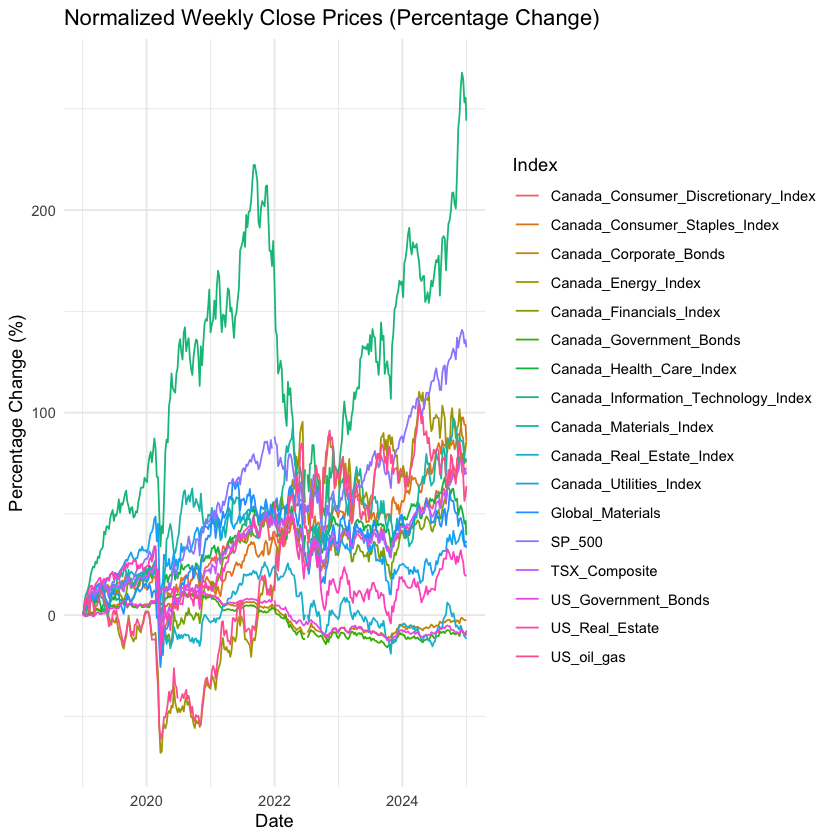

In [3]:
# Reshape data for ggplot
close_data_long <- close_data %>%
  mutate(Date = rownames(close_data)) %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100) %>%  # Normalize as percentage change
  mutate(Date = as.Date(Date))

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

In [10]:
close_data_normalized <- close_data %>%
  mutate(across(everything(), ~ (.x / first(.x) - 1) * 100))

cutoff <- as.Date('2024-01-01')
idx <- as.Date(rownames(close_data_normalized))
train <- close_data_normalized[idx <  cutoff, , drop = FALSE]
# Replace NAs in train with the last non-NA values
train <- na.locf(train, na.rm = FALSE)
test  <- close_data_normalized[idx >= cutoff, , drop = FALSE]
x_reg_cols <- setdiff(colnames(train), "TSX_Composite")
y_train <- train$TSX_Composite
y_test  <- test$TSX_Composite
xreg_train <- train[, x_reg_cols, drop = FALSE]
xreg_test  <- test[, x_reg_cols, drop = FALSE]
n_steps <- 5
n_states <- 2


In [26]:
## Create mega model with all stocks listed
## Naive model
formula <- as.formula(paste("~1 +",
  paste(colnames(close_data), collapse = " + "))
)
n_states <- 2
hid_model <- hmmTMB::MarkovChain$new(
  data = train,
  n_states = n_states,
  formula = formula,
  initial_state = 1,
  horseshoe = FALSE
)
obs_model <- hmmTMB::Observation$new(
    data = train,
    n_states = n_states,
    dists = list(TSX_Composite = "norm"),
    par = list(TSX_Composite = list(mean = c(0, 3), sd = c(1, 1))),
    # formula = list(TSX_Composite = list( mean =  ~TSX_lagged))
  )
hmm <- hmmTMB::HMM$new(hid = hid_model, obs = obs_model)

In [27]:
hmm$setup()

ERROR: Error in hmm$setup(): Log-likelihood is NaN or infinite at starting parameters. Check that the data are within the domain of definition of the observation distributions, or try other starting parameters.


In [18]:
hmm$fit_stan(iter = 1000, warmup = 500, chains = 1, refresh = 0)

#######################
## Observation model ##
#######################
+ TSX_Composite ~ lnorm(meanlog, sdlog) 
  * meanlog.state1 ~ 1
  * meanlog.state2 ~ 1
  * sdlog.state1 ~ 1
  * sdlog.state2 ~ 1
 
#########################
## State process model ##
#########################
                                                                                                                                                                                                                                                                                                                                                                                                                          state 1
state 1                                                                                                                                                                                                                                                                                                      

ERROR: Error in self$setup(silent = silent): Log-likelihood is NaN or infinite at starting parameters. Check that the data are within the domain of definition of the observation distributions, or try other starting parameters.
